In [536]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as g_filter
from astropy import units as u
import matplotlib.pyplot as plt
import pandas as pd
import sys
import ipywidgets as wwid
# sys.path.insert(0, "..")
import tools.helpers as helpers
from tools.file_finder import find_file

import tools.file_finder

In [558]:
# root = r"Z:\OPTODOCS\1Leo\L_240521/"
# root = "./"
# root2 = "../../../OPTOSYNC/Tweezers1/"
saved_pulse_folder = "./pbwx/saved_params/"
INCLUDE_TEST = True

date_nums = {
    # "210921": (30, 34, 36, 40, 41),
    # "210924": (44, 45, 46, 48),
    # "210928": (53, 56, 59, 61, 62, 63, 66, 67, 68, 69, 75, 76, 77, 74),
    "210928": (74,),
    # "211001": (6,7, 8, 10, 11, 12, 17, 19, 21, 22, 23, 
    # 24, 25, 26, 38,
    # 42,44,45,46,51,54,56),
    # ),
    # "211005": (59, 62, 65, 66, 68, 70, 72, 74, 79, 87, 88, 89)
    # "211008": (3, 5, 6, 10, 12, 13, 14, 16, 17, 18, 21, 22, 23, 25, 26, 27, 30, 32),
    # "211012":(51, 53, 55, 57, 59, 60, 68, 69, 71, 72, 73, 74, 75, 78, 79),#, 36, 38, 39, 40, 41, 42, 43, 44, )
    # "211015":(1,2,5,6,9, 10, 11, 12, 13, 15, 17, 19, 22, 23, 26, 28, 30, 32, 33, 34, 36, 38, 39, 40, 47, 49)
    # "211016": (54, 55, 58, 64, 65, 66, 67, 68, 70, 71, 73, 75),
    "211018": (103, 108, 110, 112),#, 86, 88, 90, 91, 92, 93)
    # "211019": (115, 116, 118, 121, 123, 130, 131, 132, 134, 135, 139, 140, 141),
    # "211022": (6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 
    #     25, 26, 27, 28, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59),
    # "211025": (70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 97, 101, 102, 103)
    "211026": (109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 128, 129),
}

In [559]:
# Find, possibly cache, and load data
keys = [[(k, v) for v in n] for k, n in date_nums.items()]
for k in list(keys):
    keys.remove(k)
    keys += k
keys_nice = [f"{a}-{b}" for a, b in keys]
DI = lambda n, date: keys.index((date,int(n))) + (1 if INCLUDE_TEST else 0)

def find_pulse(date, num):
    y, m, d = date[:2], date[2:4], date[4:]
    f_name = f"20{y}-{m}-{d}-{num}_pulse.txt"
    f_name = saved_pulse_folder + f_name
    data = np.genfromtxt(f_name, delimiter=",", names=True)
    return data

def DIn(*n, bool_=False):
    """ The first argument should be the date """
    date = n[0]
    val = [DI(n_, date) for n_ in n[1:]]
    if not bool_:
        return val
    else:
        zeros = np.zeros(len(keys) + (1 if INCLUDE_TEST else 0), dtype=bool)
        for v in val:
            zeros[v] = True
        return zeros
def DIb(*n):
    """ First argument should be the date """
    these_keys = [(n[0], ni) for ni in n[1:]]
    val = [k in these_keys for k in keys]
    if INCLUDE_TEST:
        val = [False] + val
    return np.array(val)
    # return DIn(*n, bool_=True)

all_of_them = np.ones(len(keys) + (1 if INCLUDE_TEST else 0), dtype=bool)
all_idxs = np.arange(len(all_of_them))

rabi_files = []
rabi_plot_files = []
for date, date_n in date_nums.items():
    for n in date_n:
        rabi_files.append(find_file("NV", n, date, True))
        rabi_plot_files.append(find_file("NV", n, date))



rabi_specs = [pd.read_csv(f, skiprows=20, names=['time', 'counts'], delimiter='\t') for f in rabi_files]
rabi_plots = [np.genfromtxt(f, skip_header=20).T for f in rabi_plot_files]
MW_freqs = []
MW_pows = []
for f in rabi_files:
    freq, powr = helpers.get_val_from_file(f, "RF freq.", "RF power")
    MW_freqs.append(freq)
    MW_pows.append(powr)



# test_time = np.arange(30000)
# test_signal = np.sin(1e-1*test_time**(0.7))
# m = test_signal > 0.75
# test_signal[m] = 10 + 3e-5 * test_time[m]
# test_signal[~m] = 0.
# plt.plot(test_time, test_signal)
# test_data = pd.DataFrame({"counts": test_signal, "time":test_time})
test_data = pd.read_csv("sim_out.txt", sep=" ", names=("time", "counts"))
if INCLUDE_TEST:
    keys_nice = ["Test"] + keys_nice

    rabi_specs = [test_data] + rabi_specs
    rabi_files = ["test signal"] + rabi_files
    MW_freqs = [2865] + MW_freqs
    MW_pows = [-8] + MW_pows

raw_titles = [x[-20:] for x in rabi_files]
proc_titles = [x[-20:] for x in rabi_plot_files]
MW_freqs = np.array(MW_freqs)
MW_pows = np.array(MW_pows)

def after(date, num):
    val = [
        (1 if (int(d) > int(date) or 
              (int(d) == int(date) and n > num)) else 0) 
        for (d, n) in keys
    ]
    if INCLUDE_TEST:
        val = [0] + val
    return np.array(val, dtype=bool)

def before(date, num):
    val = [
        (1 if (int(d) < int(date) or 
              (int(d) == int(date) and n < num)) else 0) 
        for (d, n) in keys
    ]
    if INCLUDE_TEST:
        val = [0] + val
    return np.array(val, dtype=bool)

def between(date1, n1, n2, date2=None):
    if date2 is None:
        date2 = date1
    return after(date1, n1-1) & before(date2, n2+1)

def all_b_on(date):
    if date in date_nums:
        return DIb(date, *date_nums[date])
    else:
        return ~all_of_them

def all_on(date):
    return DIn(date, *date_nums[date])

def count(bool_array):
    return len(np.flatnonzero(bool_array))


Caching...
Done.
Caching...
Done.


In [568]:
pulse_files = list(~all_of_them)
p = find_pulse("211026", 128)
pulse_files[DI(128, "211026")] = p
pulse_files[DI(129, "211026")] = p

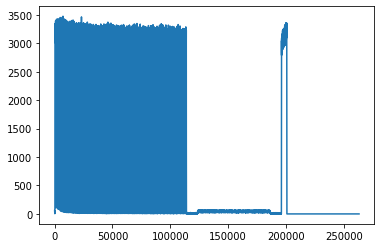

In [563]:

plot_col = None
n_cols = 4
n_rows = (n_cols - 1 + len(rabi_plots)) // n_cols

tau_axes = [r[0] for r in rabi_plots]

if plot_col is not None:
    fig = plt.figure(figsize=(n_cols*6, n_rows*5))
    axes = fig.subplots(
        nrows=n_rows, 
        ncols=n_cols, sharex="none").flatten()
    for i, (tau, plot) in enumerate(zip(tau_axes, rabi_plots)):
        ax = axes[i]
        ax.set_title(proc_titles[i])
        data = plot[plot_col]
        z_mask = data != 0.
        smoothed = g_filter(data[z_mask], 3)
        ax.plot(tau[z_mask], data[z_mask], '.-')
        ax.plot(tau[z_mask], smoothed, 'r--')

    plt.show()
else:
    plt.plot(rabi_specs[-1].counts)
    plt.show()


## Find start/end of each pulse and determine signal/reference windows

In [586]:
n_taus = np.zeros(len(all_of_them), dtype=int)
tau_starts = np.full(len(all_of_them), 20, dtype=int)
tau_ends = np.full(len(all_of_them), 1000, dtype=int)

  

integration_width_f, integration_width_b = 200, 1000 # ns
forwards_shift = -25  # Read signal shift, ns
backwards_shift = -100 # Ref signal shift, ns
first_pulse, last_pulse = -2, -1 # For graph only
extra_dead_time = 0
show_pulse = [ #0,
    DI(74, "210928"),
    # DI(11, "211022"),
    # *DIn("211001", 6, 12, 25, 26, 19, 23),
    # DI(68, "211012"),
    # DI(71, "211012"),
    # *DIn("211022", 16, 17, 18, 19),
    DI(112, "211026"),
    len(rabi_specs)-1
]

drop_ends = [0.3 for _ in rabi_specs]
# drop_ends[DI(47, "211015")] = 0.2
normalised = (all_b_on("211018") & ~DIb("211018", 110, 112)) | \
             (all_b_on("211025") & ~DIb("211025", 88, 89, 90, 91, 92)) | \
             (after("211022", 1) & ~between("211022", 8, 12) & before("211022", 42) | after("211022", 58) & before("211022", 999)) | \
             (all_b_on("211026") & ~between("211026", 118, 123))

             # DIb("211012", 68)  | \
             # all_b_on("211019") | \
             

reversed_tau = ~all_of_them
log_taus = ~all_of_them

n_taus[all_of_them] = 60
n_taus[normalised] = 50
n_taus[after("211025", 87)] = 50
# n_taus[DIb("211012", 68)] = 47
n_taus[after("211022", 1)] = 50
# log_taus[after("211022", 12) & ~DIb("211022", 25, 26) & before("211022", 59)] = True
tau_starts[between("211022", 19, 999)] = 50


const_tau = ~all_of_them
const_tau = (after("211022", 7) & before("211022", 13)) | (after("211022", 48) & before("211022", 59))
const_tau |= DIb("211026", 116, 117, 118)
tau_starts[const_tau] = 1
tau_ends[const_tau] = n_taus[const_tau]
log_taus[const_tau] = False
# n_taus[DIb("211019", 121, 123)] = 60

tau_starts[between("211025", 76, 92)] = 20
tau_starts[after("211025", 100)] = 20
tau_ends[between("211025", 76, 92)] = 300
up_sample_factor = 5
magic_number = 0xdeadbeef

210928-74


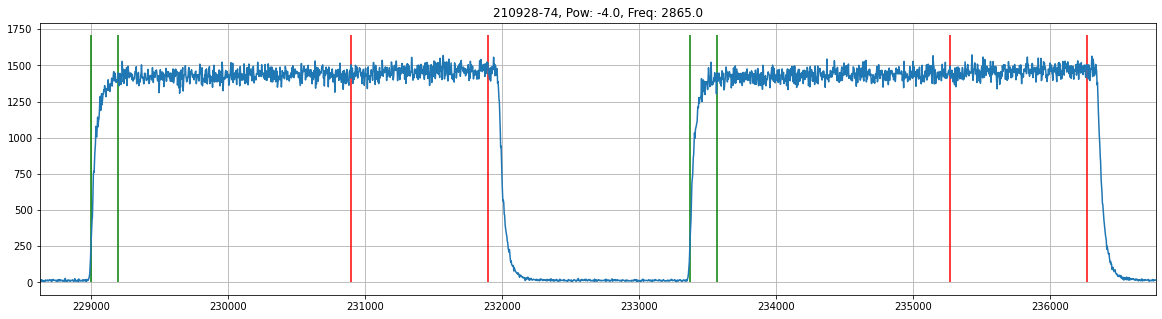

211026-112


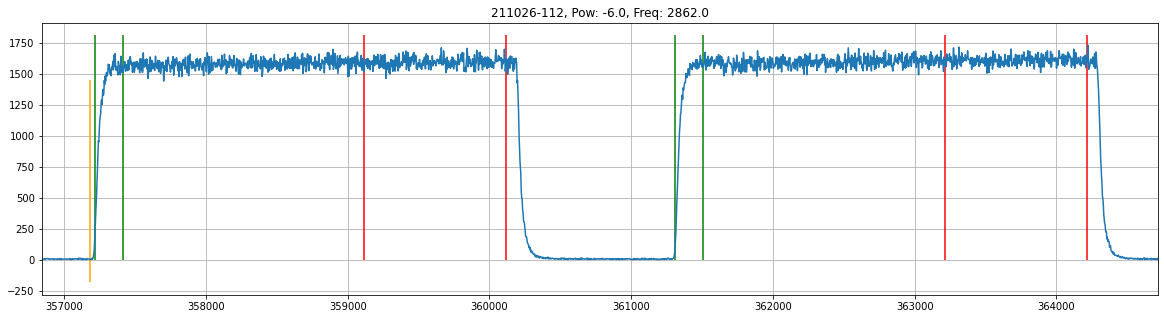

211026-129


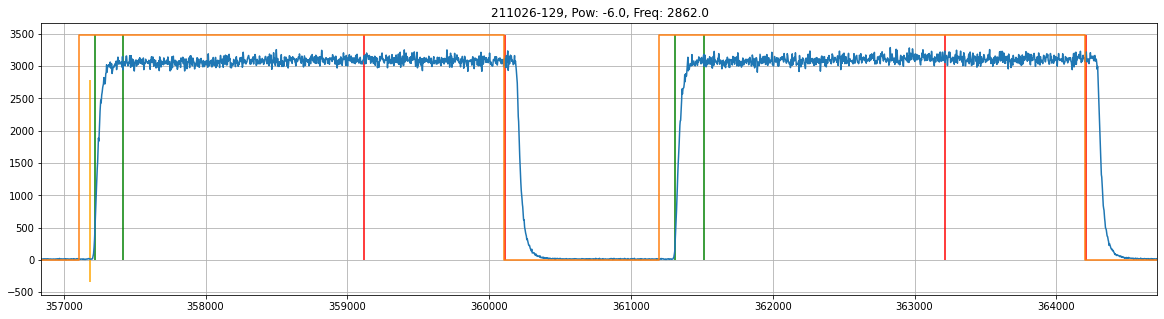

Chopping off last 1 pulses of 211026-118
Chopping off last 1 pulses of 211026-119
Chopping off last 1 pulses of 211026-120
Chopping off last 1 pulses of 211026-121


In [587]:
# Remember raw counts files are read in as panda dataframes
try:
    f = upsampled_log["f"]
    _ = my_number
except:
    upsampled_log = {}
    my_number = magic_number
else:
    if up_sample_factor != f or my_number != magic_number:
        upsampled_log = {}
        my_number = magic_number

def upsampled(spec):
    if id(spec) in upsampled_log:
        return upsampled_log[id(spec)]
    
    time, counts = spec.time, spec.counts
    init_idx = np.arange(len(time))
    new_idx = np.arange(len(time)*up_sample_factor, dtype=float) / up_sample_factor
    new_time = np.interp(new_idx, init_idx, time)
    new_counts = np.interp(new_time, time, counts)
    d = {"time":new_time, "counts":new_counts}
    try:
        spec.smooth
    except KeyError:
        pass
    else:
        d['smooth'] = g_filter(new_counts, 4*up_sample_factor)
    finally:
        df = pd.DataFrame(data=d)
        upsampled_log[id(spec)] = df
        return df
        


tau_vectors = np.array([None for _ in rabi_specs])

for i, (norm, n_tau, tau_start, tau_end, log) in enumerate(zip(normalised, n_taus, tau_starts, tau_ends, log_taus)):
    if log:
        tau_ax = np.logspace(*np.log10([tau_start, tau_end]), n_tau)
    else:
        tau_ax = np.linspace(tau_start, tau_end, n_tau)
    if norm:
        tau_vectors[i] = np.tile(tau_ax.reshape(-1, 1), (1, 2)).flatten()
    else:
        tau_vectors[i] = tau_ax
    if reversed_tau[i]:
        tau_vectors[i] = tau_vectors[i][::-1]

if INCLUDE_TEST:
    drop_ends[0] = None
    tau_vectors[0] = np.linspace(20, 1000, 60)

# Smooth raw data
for data, end_drop in zip(rabi_specs, drop_ends):
    if end_drop is not None:
        new_end = len(data.counts) * (1 - end_drop)
        new_end = int(new_end)
        data.counts = data.counts[:new_end]
        data.time = data.time[:new_end]
    data['smooth'] = g_filter(data.counts, sigma=4)

max_counts = np.array([max(data.smooth) for data in rabi_specs])
min_counts = np.array([min(data.smooth) for data in rabi_specs])

COUNTS_THRESHOLD = 0.50 # * the max number of counts in any bin

read_thresh = COUNTS_THRESHOLD * (max_counts - min_counts) + min_counts
# laser_thresh = 0.1*(max_counts - min_counts) + min_counts

ris_fals = [
    helpers.get_rise_falls(np.array(upsampled(data).smooth), thresh)
    for data, thresh in zip(rabi_specs, read_thresh)
]


rises = [rf[0] for rf in ris_fals]
# rises[-1] = rises[-1][1:]
falls = [rf[1] for rf in ris_fals]
# falls[-1] = falls[-1][1:]

rise_ts = [np.array(upsampled(data).time[r]) for data, r in zip(rabi_specs, rises)]
fall_ts = [np.array(upsampled(data).time[f]) for data, f in zip(rabi_specs, falls)]

################################################################
dt = np.array([np.diff(upsampled(spec).time)[0] for spec in rabi_specs])
int_width_b = (integration_width_b // dt).astype(int)
int_width_f = (integration_width_f // dt).astype(int)
forwards_shift_bins = (forwards_shift // dt).astype(int)
backwards_shift_bins = (backwards_shift // dt).astype(int)
################################################################

def get_readout_start_and_ends(rise_ts, fall_ts):
    """ Assumes that the first rise and fall are always 
    from the same readout pulse. """
    fin_len = min(len(rise_ts), len(fall_ts))
    result = np.zeros((fin_len, 2))
    result[:,0] = rise_ts[:fin_len]
    result[:,1] = fall_ts[:fin_len]
    return result

f = True
start_ends = [] # pairs of pulse start and end times
start_ends_idx = []
drop_first_pulse = True
for i,(spec, s_rises, s_falls, s_rise_ts, s_fall_ts) in enumerate(zip(
        rabi_specs, rises, falls, rise_ts, fall_ts)):
    spec = upsampled(spec)
        
    start_end = get_readout_start_and_ends(s_rise_ts, s_fall_ts)
    start_end_idx = get_readout_start_and_ends(s_rises, s_falls)
    start_ends.append(start_end)
    start_ends_idx.append(start_end_idx)

    if i in show_pulse: # i
        print(keys_nice[i])
        plt.figure(figsize=(20, 5))
        plt.plot(spec.time, spec.counts)
        plt.title(f"{keys_nice[i]}, Pow: {MW_pows[i]}, Freq: {MW_freqs[i]}")
        top = max(spec.counts)
        plt.vlines(forwards_shift_bins[i]*dt[i] + s_rise_ts, 0, top, "green")
        plt.vlines(forwards_shift_bins[i]*dt[i] + s_rise_ts + dt[i]*int_width_f[i], 0, top, "green")
        plt.vlines(backwards_shift_bins[i]*dt[i] + s_fall_ts, 0, top, "red")
        plt.vlines(backwards_shift_bins[i]*dt[i] + s_fall_ts - dt[i]*int_width_b[i], 0, top, "red")
        plt.xlim(s_rise_ts[first_pulse]-400, s_fall_ts[last_pulse]+400)
        if type(pulse_files[i]) is not np.bool_:
            # get the pulse data
            p = pulse_files[i]
            # Find where the trigger falls
            a = np.arange(len(p))
            trigger = p['0'] > 0
            triggered_at = a[trigger][0]
            # Get rest of pulse
            post_trigger = p[a>triggered_at]
            t_trig = np.cumsum(post_trigger['dt'])
            green_trig = post_trigger['1']

            plt.plot(t_trig+600, green_trig*top, drawstyle="steps-pre")

        if normalised[i]:
            # Show MW regions
            plt.vlines(forwards_shift_bins[i]*dt[i] + s_rise_ts[1::2] - 30, -.1*top, .8*top, "orange")
            plt.vlines(forwards_shift_bins[i]*dt[i] + s_rise_ts[1::2] - 30 - tau_vectors[i][::2], -.1*top, .8*top, "orange")
        # plt.xlim(0, s_fall_ts[5])
        f = False
        plt.grid()
        plt.show()


# readout_counts = np.array(data.counts)[[pulses[:, 0]: pulses[:, 0] + integration_width]] 
take_previous_fall = False # If false, use the fall of the same pulse as the reference signal
spec_tau_axes = []
PL_reads = []
PL_refs = []
PL_read_errs = []  # Errors are fractional
PL_ref_errs = []   # Errors are fractional
normalised_flags = np.full(len(rabi_specs), False)
for i, (spec, start_end, start_end_idx, int_w_f, int_w_b) in enumerate(zip(
        rabi_specs, start_ends, start_ends_idx, int_width_f, int_width_b)):
    # if i == 0 and INCLUDE_TEST:
    #     int_w_b = int_w_f



    spec = upsampled(spec)
    # if type(pulse_files[i]) is not np.bool_:
    #     # get the pulse data
    #     p = pulse_files[i]
    #     # Find where the trigger falls
    #     a = np.arange(len(p))
    #     trigger = p['0'] > 0
    #     triggered_at = a[trigger][0]
    #     # Get rest of pulse
    #     post_trigger = p[a>triggered_at]
    #     t_trig = np.cumsum(post_trigger['dt'])
    #     green_trig = post_trigger['1']

    #     plt.plot()
    
    forward_t = np.arange(int_w_f)
    backward_t = -np.arange(int_w_b)
    x = take_previous_fall * 1 # Scan the arrays in a fashion that depends on this setting
    forward = np.tile(forward_t, (len(start_end_idx)-x, 1)) 
    backward = np.tile(backward_t, (len(start_end_idx)-x, 1))
    if not (i == 0 and INCLUDE_TEST):
        forward += forwards_shift_bins[i]
        backward += backwards_shift_bins[i]
    reads = (forward + start_end_idx[x:, [0]]).astype(int)
    refs = (backward + start_end_idx[:len(start_end_idx)-x, [1]]).astype(int)

    tau = start_end[1:, 0] - start_end[:-1, 1] + dt[i]*(backwards_shift_bins[i] - forwards_shift_bins[i])
    tau -= extra_dead_time * dt[i]
    # if not take_previous_fall ignore the first pulse
    reads_i = reads[1-x:]
    refs_i  = refs[1-x:]

    arr = np.array(spec.counts)
    reads = np.sum(arr[reads_i], axis=-1)
    refs  = np.sum(arr[refs_i], axis=-1)
    noise = np.std(arr[refs_i], axis=-1) / np.mean(arr[refs_i], axis=-1)
    # if i == DI(11, "211022"):
    #     print(reads)
    #     print(reads.shape)
    #     print(arr[reads_i].shape)
    #     plt.plot(arr[reads_i][:,0])
    
    # if i in normalised:
    #     plt.plot(reads[::2])
    #     plt.plot(reads[1::2])
    #     plt.show()
    #     reads = reads[::2] / reads[1::2]
    #     refs = refs[::2] / refs[1::2]
    #     noise = noise[::2]
    #     tau = tau[::2]

    refs_err = noise / np.sqrt(int_w_b)
    read_err = noise / np.sqrt(int_w_f)
    reads /= int_w_f
    refs /= int_w_b


    # if np.any(np.diff(tau) < -10):
    #     # Probably data that includes normalisation, ie a background sweep.
    #     # divide the first half by the second half
    #     indx = np.flatnonzero((tau[1:]-tau[:-1]) < -10)[0]
    #     # print(i, ": ", end="")
    #     # print(len(reads), len(refs), indx)
    #     normalised_flags[i] = True
    #     # if indx == 0:
    #         # print(np.diff(tau))
    #     # print("Fixing %s which was run with 'normalise' turned on" % rabi_files[i][-30:])
    #     reads = reads[:indx+1] / reads[indx+1 + (1-x):]
    #     refs = refs[:indx+1] / refs[indx+1 + (1-x):]
    #     # if i > 25:
    #     tau = tau[:indx+1]

    if tau_vectors[i] is not None:
        l = len(tau_vectors[i])
        if l < len(reads):
            print("Chopping off last", len(reads) - l, "pulses of", keys_nice[i])
            tau = tau[:l]
            reads = reads[:l]
            read_err = read_err[:l]
            refs = refs[:l]
            refs_err = refs_err[:l]
        elif l > len(reads):
            print("Missing", l - len(reads), "pulses for", keys_nice[i])

    spec_tau_axes.append(tau)
    PL_reads.append(reads)
    PL_read_errs.append(read_err)
    PL_refs.append(refs)
    PL_ref_errs.append(refs_err)

# PL_reads[-1] = PL_reads[-1][1:]
# PL_refs[-1] = PL_refs[-1][1:]
# spec_tau_axes[-1] = spec_tau_axes[-1][1:]
# del upsampled_log


(139610.88, 143386.88)

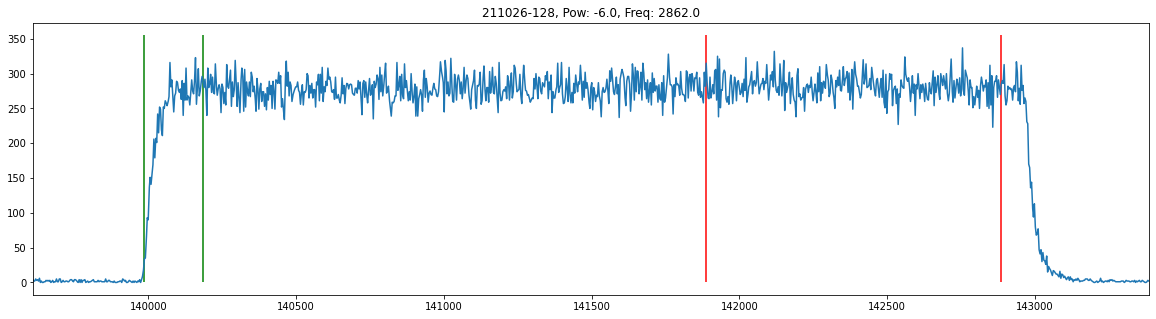

In [579]:
i = -2# DI(103, "211025")
spec = upsampled(rabi_specs[i])
plt.figure(figsize=(20, 5))
plt.plot(spec.time, spec.counts)
plt.title(f"{keys_nice[i]}, Pow: {MW_pows[i]}, Freq: {MW_freqs[i]}")
top = max(spec.counts)
plt.vlines(forwards_shift_bins[i]*dt[i] + s_rise_ts, 0, top, "green")
plt.vlines(forwards_shift_bins[i]*dt[i] + s_rise_ts + dt[i]*int_width_f[i], 0, top, "green")
plt.vlines(backwards_shift_bins[i]*dt[i] + s_fall_ts, 0, top, "red")
plt.vlines(backwards_shift_bins[i]*dt[i] + s_fall_ts - dt[i]*int_width_b[i], 0, top, "red")
plt.xlim(s_rise_ts[42]-400, s_fall_ts[42]+400)

211026-113


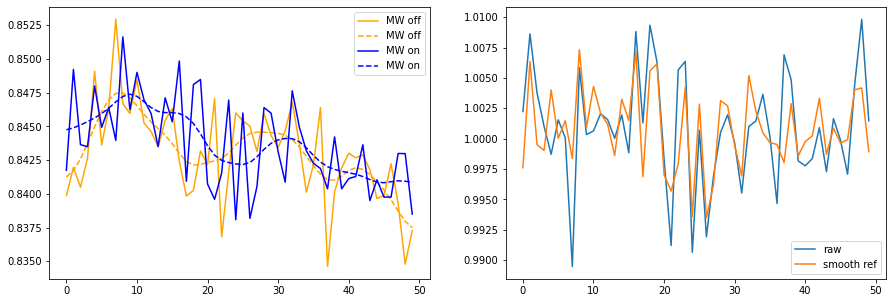

211026-114


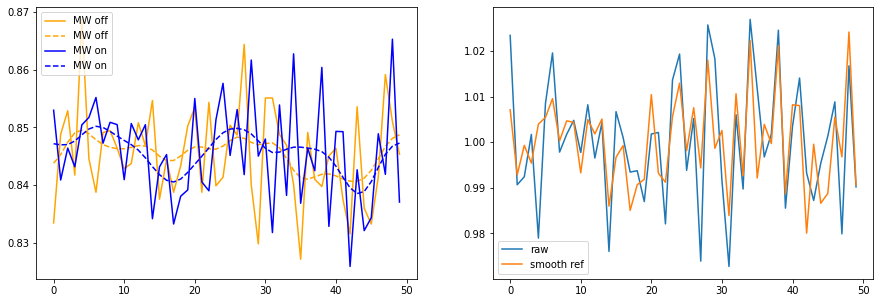

211026-115


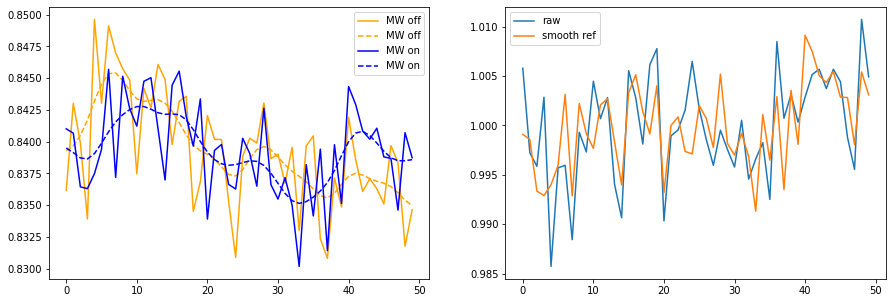

211026-116


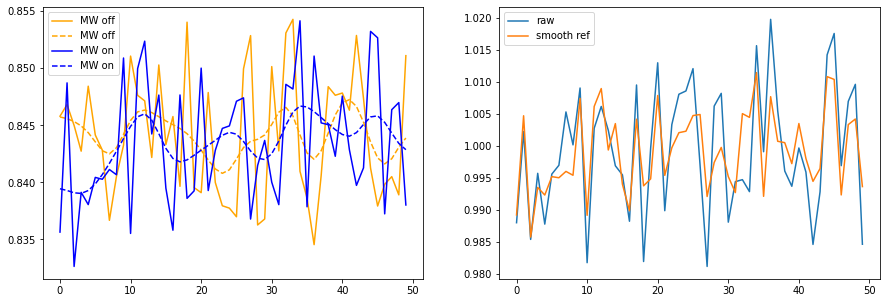

211026-117


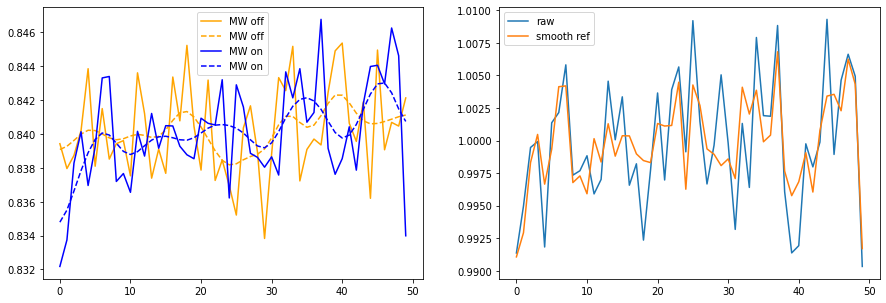

In [544]:
# n = normalised[-1]#DI(38, "211015")
for n in all_idxs[normalised][-5:]:
    print(keys_nice[n])
    read_n = PL_reads[n]
    ref_n = PL_refs[n]
    fig = plt.figure(figsize=(15, 5))
    ax1, ax2 = fig.subplots(ncols=2).flatten()
    MW_signal = read_n[::2] / ref_n[::2]
    norm_signal = read_n[1::2] / ref_n[1::2]
    ax1.plot(norm_signal, c="orange", label="MW off")
    ax1.plot(g_filter(norm_signal, 2), "--", c="orange", label="MW off")
    ax1.plot(MW_signal, c="blue", label="MW on")
    ax1.plot(g_filter(MW_signal, 2), "--", c="blue", label="MW on")
    ax1.legend()
    ax2.plot(MW_signal / norm_signal, label="raw")
    ax2.plot(MW_signal / g_filter(norm_signal, sigma=5), label="smooth ref")
    ax2.legend()
    plt.show()
# plt.plot(g_filter(MW_signal, 3) / g_filter(norm_signal, 3), label="Mw on")

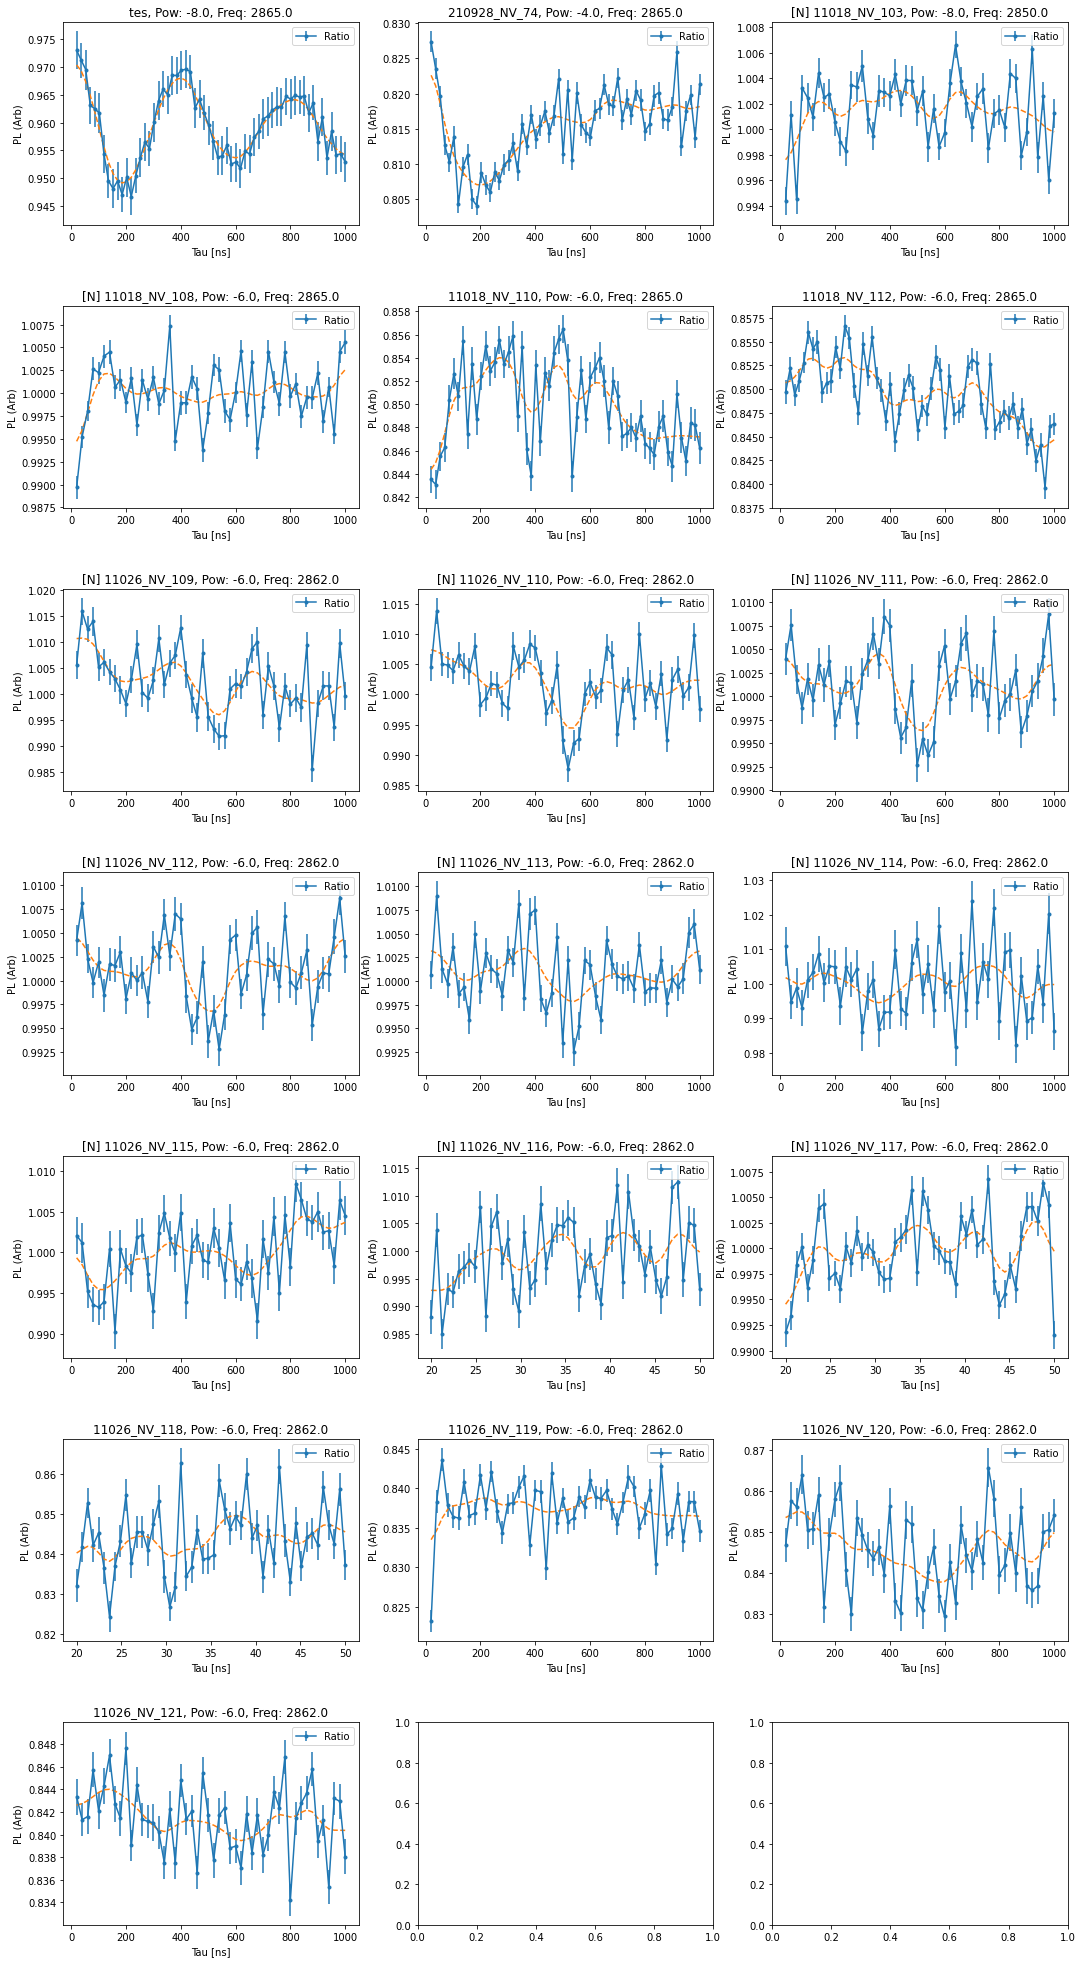

In [545]:
# Plot signals
smoothed_series = None
save_plots = True
# @wwid.interact(graph_type=["Ratio", "Difference", "Both"])
def _do_plot(graph_type="Ratio"):
    global smoothed_series
    n_cols = 3
    n_rows = (len(rabi_files)+n_cols-1+1)//n_cols # +1 for the totals plot at the end
    fig = plt.figure(figsize=(n_cols*6, 5*n_rows))
    smoothing_sigma = 2

    axes = fig.subplots(
        nrows=n_rows,
        ncols=n_cols,
        sharex="none").flatten()
    smoothed_series = []
    for i, (title, tau, read, read_err, ref, ref_err, ax) in enumerate(
            zip(raw_titles, spec_tau_axes, PL_reads, PL_read_errs, PL_refs, PL_ref_errs, axes)):
        if normalised_flags[i] or normalised[i]:
            title = "[N] " + title
        if tau_vectors[i] is not None:
            tau = tau_vectors[i]
            read = read[:len(tau)]
            ref = ref[:len(tau)]
        read = read
        ref  = ref
        ax.set_title(title[:-8] + ", Pow: " + str(MW_pows[i]) + ", Freq: " + str(MW_freqs[i]))
        diff = ref - read
        ratio = read / ref
        diff = diff / max(diff) * ratio[0]
        smooth_diff = g_filter(diff, smoothing_sigma)
        smooth_ratio = g_filter(ratio, smoothing_sigma)
        smooth_read = g_filter(read, smoothing_sigma)
        smooth_ref = g_filter(ref, smoothing_sigma)
        if normalised[i]:
            signal = ratio[::2]
            norm = ratio[1::2]
            smooth_norm = g_filter(norm, smoothing_sigma)
            ratio = signal / smooth_norm
            smooth_ratio = g_filter(ratio, smoothing_sigma)
            # ratio = ratio[::2]

            # smooth_read = smooth_read[::2] / smooth_read[1::2]
            # smooth_ratio = smooth_ratio[::2] / smooth_ratio[1::2]
            tau = tau[::2]
            read_err = read_err[::2]
            ref_err = ref_err[::2]
        if graph_type == "Difference":
            ax.plot(tau, diff, "-", label="Diff") 
        elif graph_type == "Ratio":
            # Add fractional uncertainties
            # if i>0: print(ratio * ref_err/ref)
            ratio_err = (read_err + ref_err) * ratio

            try:
                ax.errorbar(tau, ratio, yerr=ratio_err, fmt=".-", label="Ratio"); ax.plot(tau, smooth_ratio, "--")
            except ValueError:
                print("tau shape:", np.shape(tau))
                print("ratio shape:", np.shape(ratio))
            # if not "test" in title:
            smoothed_series.append((tau, smooth_ratio, ratio, ratio_err))
        elif graph_type == "Both":
            ax.plot(tau, read, label="PL Read")
            ax.plot(tau, ref, label="PL Ref")
        ax.set_xlabel("Tau [ns]")
        ax.set_ylabel("PL (Arb)")
        ax.legend()
        # break
    # ax.set_xlim(4000,10000)
    # ax.set_ylim(0.97, 1.025)
    # if smoothed_series:
    #     for i, series in enumerate(smoothed_series):
    #         axes[-1].plot(series[0], .00*i+1+series[1] - series[1][0], "blue")
    #     axes[-1].set_title("All smoothed curves")
    plt.subplots_adjust(hspace=0.4)
    plt.show()

    # slc = slice(1, 5)
_do_plot(graph_type="Ratio")

    # avg = np.sum([read/ref for read, ref in zip(PL_reads[slc], PL_refs[slc])], axis=0)
    # plt.plot(spec_tau_axes[1], avg)

In [546]:
rd = lambda date, *n : [DI(n_, date) for n_ in n]
first_tau_chop = 3 # First number of pulses to ignore
reversed = ~all_of_them
off_res = ~all_of_them
amp_off = DIb("211018", 112) | between("211025", 88, 92)
already_normalised = normalised
normalise = True
norm_tau, norm_array = smoothed_series[DI(92, "211025")][:2]
# runs = [*rd("211008", 6, 10, 12, 13, 14, 16, 17, 18,)]# 21, 22, 27, 29)]
runs_b = all_of_them
runs = all_idxs[runs_b]
# runs = runs[MW_pows[runs].argsort()]
pi_lower, pi_upper = 50, 800
decay_lower, decay_upper = 50, np.inf


ValueError: ('211025', 92) is not in list

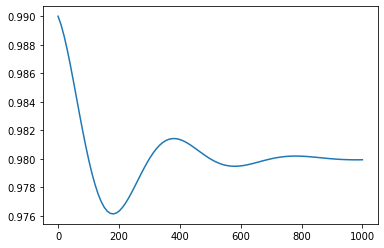

Failed to fit for 211022-17
Failed to fit for 211025-88
Failed to fit for 211025-89
Failed to fit for 211025-97


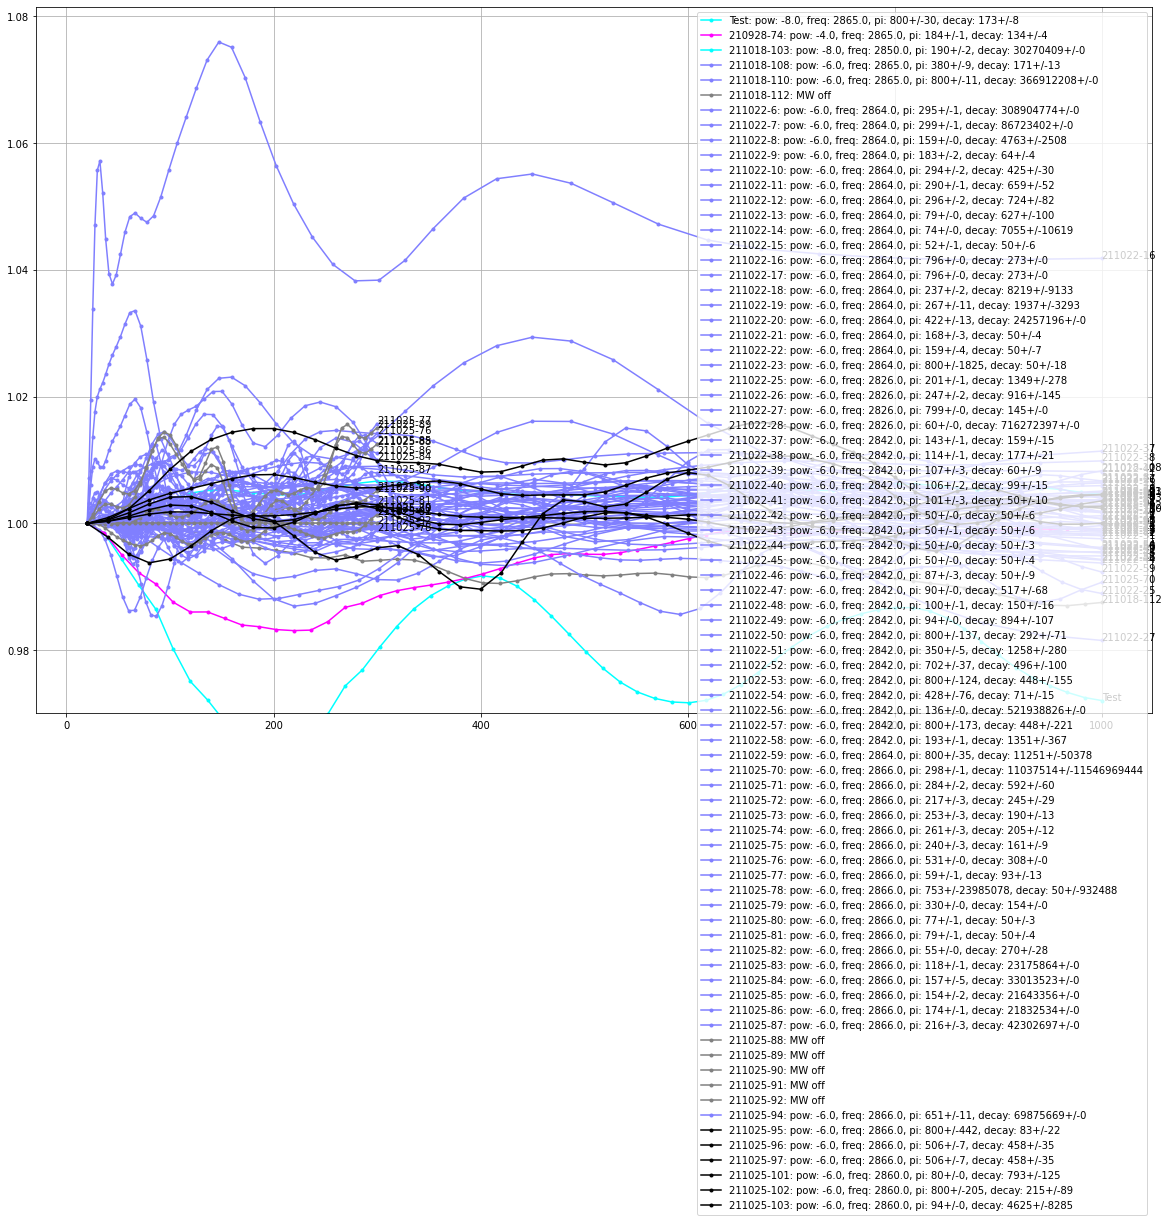

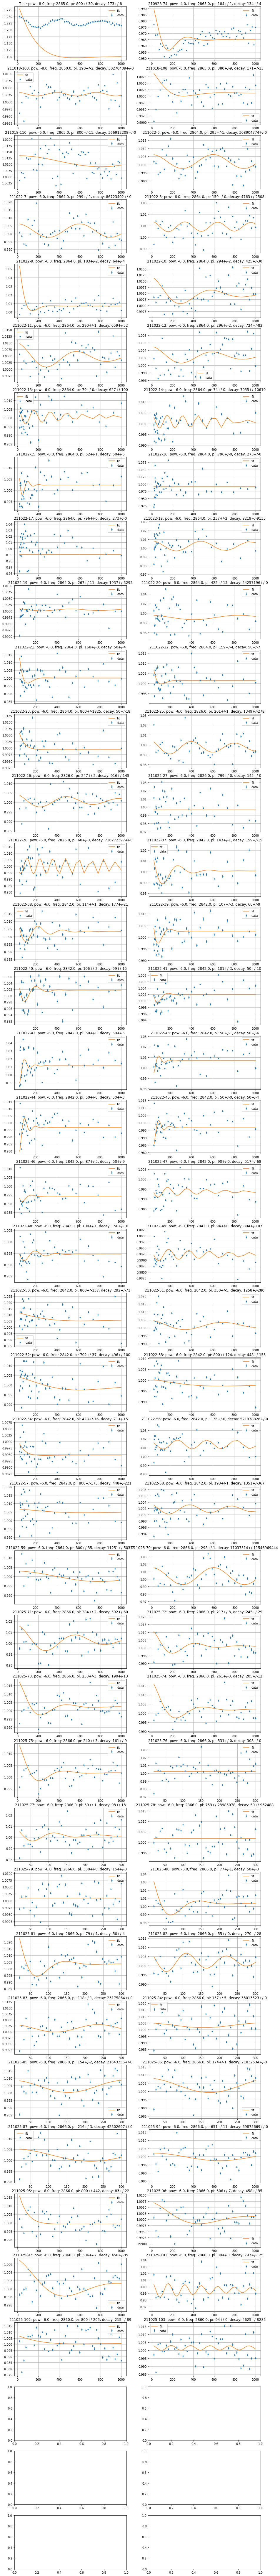

In [ ]:
# Plot normalised rabi curves
# r = lambda n : DI(n, "210928")
r2 = lambda *n : [DI(n_, "211001") for n_ in n] if len(n) > 1 else DI(n[0], "211001")


# reversed = [
#     r2(12), #r2(26)
# ]
# off_res = [
#     *rd("211001", 19)
# ]
# amp_off = [
#     *rd("211001", 23), *rd("211008", 6, 17)
# ]
# run_nums = []#6, 7, 8, 10, 11, 12, 19, 23]#, 17, 21, 22, 24, 25, 19, 23]
# # run_nums = [23, 22, 21, 24, 25, 26][2:]
# runs = [*rd("211001", *run_nums), *rd("211008", 6, 10, 12, 13, 14, 16, 17)]
powered_runs = runs_b & ~amp_off


# runs = [i for i in range(len(rabi_specs)-1)]
pow_range = MW_pows[powered_runs] #np.array([n for n in runs], dtype=float)
pow_0to1 = pow_range - min(pow_range)

if not np.all(pow_0to1 == 0):
    pow_0to1 /= max(pow_0to1)
cmap = plt.cm.cool(pow_0to1)

def rabi_f(tau, pi_t, decay_t, base, amp):
    return amp*np.cos(tau * (np.pi/pi_t)) * np.exp(-tau/decay_t) + base

init_p = (200, 200, .98, 0.01)
test_tau = np.linspace(0, 1000, 100)
plt.plot(test_tau, rabi_f(test_tau, *init_p))
plt.show()

lil_fig = plt.figure(figsize=(20, 13))
lil_ax = lil_fig.gca()
n_cols=2
n_rows = (len(powered_runs)+1)//n_cols
big_fig = plt.figure(figsize=(15, 4*n_rows))
big_fig_axes = big_fig.subplots(nrows=n_rows, ncols=n_cols).flatten()
bfi = 0 # big fig axes index
off_runs = runs_b & amp_off
all_runs = off_runs | powered_runs
all_clrs = list(cmap) + ["k"] * count(off_runs)
normalised_series = [None for _ in smoothed_series] 
pi_times = []
pi_err = []
pi_pow = []
# sort = MW_pows.argsort()
for n, c in zip(all_idxs[all_runs], all_clrs):
    tau_ax, vals, ratio, ratio_err = smoothed_series[n]
    if reversed[n]:
        vals = vals[::-1]
        tau_ax = tau_ax[::-1]
    if off_res[n]:
        c = "black"
    if amp_off[n]:
        c = "gray"

    if normalise:
        if not already_normalised[n]:
            vals = vals / np.interp(x=tau_ax, xp=norm_tau, fp=norm_array)
            ratio = ratio / np.interp(x=tau_ax, xp=norm_tau, fp=norm_array)
        normalised_series[n] = (tau_ax, vals)
        try:
            popt, pcov = curve_fit(rabi_f, tau_ax[first_tau_chop:], ratio[first_tau_chop:], p0=init_p,
                bounds=([pi_lower, decay_lower, 0.8, 0], [pi_upper, decay_upper, 1.1, 0.2]),
                sigma=ratio_err[first_tau_chop:], absolute_sigma=True)#np.linspace(1., 0.3, len(tau_ax), endpoint=False))
        except RuntimeError:
            print("Failed to fit for %s" % keys_nice[n])
        except ValueError:
            print("Bad values in %s" % keys_nice[n])
        perr = np.sqrt(np.diag(pcov))
    if off_runs[n]:
        l = f"{keys_nice[n]}: MW off"
    else:
        l = f"{keys_nice[n]}: pow: {MW_pows[n]}, freq: {MW_freqs[n]}, pi: {popt[0]:.0f}+/-{perr[0]:.0f}, decay: {popt[1]:.0f}+/-{perr[1]:.0f}"
    if normalise:
        if powered_runs[n]:
            ax = big_fig_axes[bfi]
            ax.errorbar(tau_ax, ratio, yerr=ratio_err, fmt='.', label="data")
            ax.plot(tau_ax, rabi_f(tau_ax, *popt), "-", label="fit")
            ax.set_title(l)
            ax.grid(True)
            ax.legend()
            bfi += 1
            pi_times.append(popt[0])
            pi_err.append(perr[0])
            pi_pow.append(MW_pows[n])

    vals = vals - vals[0] + 1
    lil_ax.plot(tau_ax, vals, '.-', color=c, label=l)
    # if normalise:
        # lil_ax.plot(tau_ax, rabi_f(tau_ax, *popt), color=c, label=l)
        # print(perr, popt)
    lil_ax.annotate(f"{keys_nice[n]}", (tau_ax[-1], vals[-1]))
lil_ax.grid()
lil_ax.set_ylim(bottom=.97)
lil_ax.legend()
plt.show()


In [ ]:
pow_0to1

array([0. , 1. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

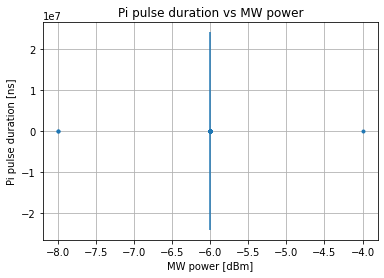

In [ ]:
plt.grid()
plt.title("Pi pulse duration vs MW power")
plt.ylabel("Pi pulse duration [ns]")
plt.xlabel("MW power [dBm]")
plt.errorbar(pi_pow, pi_times, yerr=pi_err, fmt=".")
# plt.ylim(bottom=0, top=800)
plt.show()